<a href="https://colab.research.google.com/github/Befezdow/ai_test/blob/master/course_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [60]:
from google.colab import drive
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

drive.mount('/content/gdrive')
names_array = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(60000)]]
url = '/content/gdrive/My Drive/ML/half.csv'
data = pd.read_csv(url, names=names_array)

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Подготавливаем данные, заполняя пропущенные значения медианой.

In [61]:
data = data.fillna(data.median(axis = 0), axis = 0)
data

,gender,age,class1,class2,class3,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,...,t59961,t59962,t59963,t59964,t59965,t59966,t59967,t59968,t59969,t59970,t59971,t59972,t59973,t59974,t59975,t59976,t59977,t59978,t59979,t59980,t59981,t59982,t59983,t59984,t59985,t59986,t59987,t59988,t59989,t59990,t59991,t59992,t59993,t59994,t59995,t59996,t59997,t59998,t59999,t60000
0,Female,85,3,5.0,NaN,0.003242,0.012132,0.022637,0.010953,-0.024891,-0.032752,-0.031432,-0.042890,-0.048659,-0.037955,-0.026816,-0.017216,-0.014815,-0.024370,-0.027953,-0.037105,-0.046662,-0.052641,-0.054785,-0.054178,-0.034856,-0.023726,-0.036748,-0.031842,-0.021913,-0.038332,-0.045422,-0.044497,-0.042550,-0.038772,-0.043089,-0.055117,-0.062105,-0.062300,-0.062635,...,-0.026842,-0.028914,-0.028548,-0.029272,-0.031896,-0.036031,-0.039794,-0.033593,-0.028113,-0.031301,-0.041995,-0.045999,-0.043968,-0.039291,-0.030942,-0.031698,-0.030754,-0.033479,-0.033446,-0.036413,-0.038551,-0.035920,-0.036477,-0.036518,-0.041184,-0.039042,-0.033992,-0.033940,-0.031528,-0.026267,-0.028246,-0.028318,-0.025569,-0.021279,-0.018593,-0.032023,-0.046202,-0.042003,-0.034466,-0.039000
1,Male,79,9,5.0,NaN,0.012054,0.017017,0.015951,0.020941,0.020960,0.021158,0.021051,0.021062,0.021122,0.021278,0.026533,0.026235,0.016037,0.013366,0.013222,0.008356,0.005556,0.007938,0.008593,0.008398,0.008547,0.008369,0.008677,0.006235,0.000651,-0.001857,-0.001712,-0.007047,-0.009004,-0.012014,-0.019256,-0.019027,-0.019518,-0.018919,-0.020128,...,-0.934049,-0.949376,-0.962051,-0.963686,-0.961742,-0.952030,-0.939060,-0.934415,-0.936366,-0.939326,-0.932011,-0.926725,-0.928331,-0.929013,-0.921389,-0.906309,-0.900787,-0.901273,-0.895911,-0.893740,-0.891627,-0.885869,-0.881577,-0.873489,-0.866113,-0.865862,-0.859139,-0.852907,-0.843380,-0.833925,-0.833698,-0.836701,-0.827418,-0.827810,-0.816231,-0.819793,-0.797862,-0.819597,-0.771195,-0.845490
2,Male,66,3,5.0,NaN,-0.009508,-0.008508,-0.009508,-0.008508,-0.007508,-0.006508,-0.006508,-0.006508,-0.005508,-0.006508,-0.005508,-0.004508,-0.003508,-0.004508,-0.004508,-0.004508,-0.005508,-0.004508,-0.003508,-0.004508,-0.003508,-0.002508,-0.000508,-0.001508,-0.000508,-0.000508,-0.001508,-0.001508,-0.001508,-0.000508,0.000492,0.002492,0.005492,0.006492,0.007492,...,-0.051053,-0.052053,-0.051053,-0.049053,-0.047053,-0.044053,-0.040053,-0.037053,-0.036053,-0.034053,-0.034053,-0.034053,-0.033053,-0.031053,-0.028053,-0.025053,-0.022053,-0.019053,-0.017053,-0.017053,-0.016053,-0.016053,-0.014053,-0.013053,-0.010053,-0.007053,-0.003053,0.001947,0.004947,0.007947,0.009947,0.011947,0.012947,0.015947,0.018947,0.023947,0.027947,0.030947,0.034947,0.037947
3,Male,93,2,5.0,NaN,-0.002271,0.004177,-0.002077,-0.005875,-0.004685,-0.008117,-0.019722,-0.036185,-0.037616,-0.025323,-0.023199,-0.035744,-0.043484,-0.030469,-0.022611,-0.010540,0.004805,0.020337,0.029668,0.017382,0.004737,0.002755,0.014075,0.015677,0.002024,-0.002544,0.000068,0.000271,0.011654,0.022805,0.028631,0.029834,0.030584,0.035327,0.051485,...,-0.117502,-0.208445,-0.254530,-0.270954,-0.254278,-0.223832,-0.205055,-0.179093,-0.157585,-0.127692,-0.089728,-0.074150,-0.056856,-0.038932,-0.024184,-0.016817,-0.014031,-0.011765,-0.022771,-0.023586,-0.013769,-0.004949,-0.003625,-0.013567,-0.019471,-0.015372,-0.021787,-0.028885,-0.028997,-0.021737,-0.013160,-0.006182,-0.003825,-0.002177,-0.001466,-0.006676,-0.011236,-0.016540,-0.016289,-0.022542
4,Male,65,2,5.0,NaN,-0.030600,-0.027425,-0.013923,-0.023743,-0.024572,-0.036078,-0.034740,-0.013670,-0.009571,-0.022441,-0.033034,-0.032663,-0.018181,-0.017317,-0.030576,-0.032829,-0.010305,0.005287,0.006696,-0.002352,-0.005559,-0.005361,-0.008254,0.002175,0.007531,0.002662,0.000376,-0.007697,-0.016977,-0.009894,-0.000388,-0.012127,-0.007840,-0.002470,-0.005233,...,1.016910,0.710028,0.406775,0.104651,-0.181270,-0.432753,-0.645005,-0.816434,-0.952654,-1.038151,-1.073172,-1.060904,-1.006902,-0.914312,-0.803500,-0.697

Осуществляем аугментацию данных. На каждый датчик идет по 5000 записей. Разбиваем так, чтобы на каждый приходилось по 100, тем самым размножая данные.

In [0]:
current_count_per_sensor = 5000
needed_count_per_sensor = 100
sensors_count = 12

non_sliceable_columns = data.iloc[:,0:5]
sliceable_columns = data.iloc[:,5:]

current_offset = 0
new_data = pd.DataFrame()
for i in range(int(np.floor(current_count_per_sensor / needed_count_per_sensor))):
  new_offset = current_offset + needed_count_per_sensor
  new_slice = pd.DataFrame()
  
  for j in range(sensors_count):
    index_from = j * current_count_per_sensor + current_offset
    index_to = j * current_count_per_sensor + new_offset
    data_slice = sliceable_columns.iloc[:, index_from:index_to]
    new_slice = pd.concat([new_slice, data_slice], axis=1, sort=False, ignore_index=True)
  
  completed_rows = pd.concat([non_sliceable_columns.copy(), new_slice], axis=1, sort=False, ignore_index=True)
  new_data = pd.concat([new_data, completed_rows], axis=0, sort=False, ignore_index=True)
  current_offset += needed_count_per_sensor

new_data.columns = ['gender', 'age', 'class1', 'class2', 'class3', *['t{}'.format(i + 1) for i in range(needed_count_per_sensor * sensors_count)]]

In [0]:
data = new_data

Выкидываем лишние классовые признаки, а затем осуществляем векторизацию и нормализацию данных.

In [64]:
# убираем лишние классовые признаки
data = data.drop('class2', axis = 1)
data = data.drop('class3', axis = 1)

#собираем числовые колонки
numerical_columns = [c for c in data.columns if data[c].dtype.name != 'object' and c != 'class1']

# векторизируем колонку gender
data.at[data['gender'] == 'Male', 'gender'] = 0
data.at[data['gender'] == 'Female', 'gender'] = 1

# нормализуем числовые атрибуты
data_numerical = data[numerical_columns]
data_numerical = (data_numerical - data_numerical.mean(axis = 0))/data_numerical.std(axis = 0)
data[numerical_columns] = data_numerical

data

,gender,age,class1,t1,t2,t3,t4,t5,t6,t7,t8,t9,t10,t11,t12,t13,t14,t15,t16,t17,t18,t19,t20,t21,t22,t23,t24,t25,t26,t27,t28,t29,t30,t31,t32,t33,t34,t35,t36,t37,...,t1161,t1162,t1163,t1164,t1165,t1166,t1167,t1168,t1169,t1170,t1171,t1172,t1173,t1174,t1175,t1176,t1177,t1178,t1179,t1180,t1181,t1182,t1183,t1184,t1185,t1186,t1187,t1188,t1189,t1190,t1191,t1192,t1193,t1194,t1195,t1196,t1197,t1198,t1199,t1200
0,1,1.177851,3,0.024810,0.089641,0.166249,0.079260,-0.183195,-0.239878,-0.229224,-0.311345,-0.353593,-0.276569,-0.194899,-0.124608,-0.107193,-0.176887,-0.201853,-0.266702,-0.334036,-0.375456,-0.389888,-0.385213,-0.248611,-0.170733,-0.265279,-0.231965,-0.162420,-0.280354,-0.328905,-0.320951,-0.306322,-0.279457,-0.310764,-0.396990,-0.447620,-0.450523,-0.453223,-0.495634,-0.503300,...,-0.281762,-0.281652,-0.282679,-0.280107,-0.265826,-0.244599,-0.226658,-0.234529,-0.236443,-0.258389,-0.269397,-0.244040,-0.233612,-0.233914,-0.240705,-0.260236,-0.264701,-0.214605,-0.232482,-0.247209,-0.285343,-0.309315,-0.304806,-0.269721,-0.277915,-0.276932,-0.274276,-0.224491,-0.258844,-0.260899,-0.258333,-0.254184,-0.247342,-0.230120,-0.231861,-0.225600,-0.247128,-0.245634,-0.256841,-0.266626
1,0,0.808696,9,0.089633,0.125414,0.117306,0.152087,0.150359,0.150870,0.149757,0.150433,0.151931,0.153868,0.192854,0.190815,0.116619,0.096582,0.095752,0.060556,0.039466,0.055681,0.060328,0.059317,0.059936,0.057892,0.059589,0.041363,-0.000022,-0.017737,-0.015379,-0.053639,-0.067829,-0.089579,-0.141626,-0.140784,-0.145060,-0.141832,-0.150440,-0.158980,-0.179465,...,1.277399,1.591452,1.949256,2.391251,2.901596,3.449840,3.954929,4.400384,4.779853,5.034665,5.030888,4.715864,4.194606,3.611433,3.115175,2.691228,2.311560,1.656903,1.643013,1.397020,1.215765,1.104194,1.042477,0.905557,0.931156,0.852095,0.756517,0.564518,0.604893,0.561188,0.533448,0.526664,0.530455,0.548706,0.558310,0.489712,0.516571,0.494300,0.479337,0.461718
2,0,0.008860,3,-0.068971,-0.061504,-0.069057,-0.062645,-0.056737,-0.049656,-0.049243,-0.048640,-0.040985,-0.048046,-0.040027,-0.032355,-0.025167,-0.032945,-0.032398,-0.032047,-0.039668,-0.032895,-0.025633,-0.032362,-0.025760,-0.019588,-0.006100,-0.014220,-0.008364,-0.008024,-0.013914,-0.014101,-0.014534,-0.007926,-0.001476,0.011986,0.032624,0.038989,0.046299,0.054910,0.056669,...,0.342476,0.363231,0.381090,0.392754,0.404233,0.416104,0.424317,0.434898,0.445092,0.451531,0.457970,0.458525,0.455772,0.455779,0.452729,0.447419,0.445639,0.374290,0.443081,0.440583,0.437367,0.431717,0.425354,0.380314,0.403103,0.394827,0.386485,0.321049,0.376301,0.371144,0.362767,0.356300,0.351041,0.339018,0.326720,0.289190,0.305516,0.292793,0.279864,0.265344
3,0,1.670058,2,-0.015739,0.031386,-0.014660,-0.043449,-0.036202,-0.061322,-0.144660,-0.262930,-0.273593,-0.184770,-0.168607,-0.259108,-0.315176,-0.221083,-0.163240,-0.075470,0.034093,0.143924,0.210039,0.123139,0.032848,0.017904,0.098192,0.109136,0.009856,-0.022685,-0.002609,-0.001402,0.079040,0.157510,0.198223,0.206091,0.210890,0.244174,0.359667,0.420744,0.257516,...,-0.082333,-0.057747,-0.029369,-0.023311,-0.013463,-0.002650,-0.002732,-0.000867,-0.001111,-0.000607,-0.000472,-0.000599,0.000362,-0.000267,0.006970,0.010258,0.009969,-0.007767,-0.012269,-0.002452,-0.011535,-0.012707,-0.014890,-0.022144,-0.022074,-0.023712,-0.016937,-0.016193,-0.039933,-0.058460,-0.060961,-0.055542,-0.052412,-0.052737,-0.033069,-0.017898,-0.034528,-0.032431,-0.049405,-0.045061
4,0,-0.052666,2,-0.224116,-0.200036,-0.101375,-0.173736,-0.180879,-0.263988,-0.253109,-0.100358,-0.070424,-0.163826,-0.240091,-0.236738,-0.131612,-0.125774,-0.220814,-0.235917,-0.073979,0.036815,0.046850,-0.017050,-0.040342,-0.039913,-0.061496,0.012219,0.049496,0.014800,-0.000405,-0.058276,-0.124513,-0.074536,-0.007725,-0.091796,-0.062091,-0.024787,-0.044343,0.028531,-0.055587,...,-0.049339,-0.049629,-0.048969,-0.048647,-0.047396,-0.047525,-0.037144,-0.019713,-0.018608,-0.016827,-0.002320,-0.006999,-0.009981,-0.007894,-0.010623,-0.022330,-0.025839,-0.029534,-0.030805,-0.02

Разбиваем данные на входы и выходы.

In [0]:
# бьем данные на входы и выходы
x = data.drop('class1', axis = 1)
y = data['class1']

Разбиваем данные на обучающую и тестовую выборки.

In [66]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

n_train, _ = x_train.shape 
n_test,  _ = x_test.shape 

print('Train dataset size: {}'.format(n_train))
print('Test dataset size: {}'.format(n_test))

Train dataset size: 43750
Test dataset size: 18750


In [0]:
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

Заворачиваем данные в тензоры. Это необходимо для pytorch.

In [68]:
import torch

x_train = torch.Tensor(x_train)
y_train = torch.Tensor(y_train).long() - 1

x_test = torch.Tensor(x_test)
y_test = torch.Tensor(y_test).long() - 1

print('Train X shape: {}'.format(x_train.shape))
print('Train Y shape: {}'.format(y_train.shape))

print('Test X shape: {}'.format(x_test.shape))
print('Test Y shape: {}'.format(y_test.shape))

Train X shape: torch.Size([43750, 1202])
Train Y shape: torch.Size([43750])
Test X shape: torch.Size([18750, 1202])
Test Y shape: torch.Size([18750])


Инициализируем нейронную сеть. Она будет иметь 2 внутренних слоя по 500 нейронов. В качестве логистической функции используем relu на внутренних слоях, на выходах - softmax. 
Оптимизатор: Adam (до этого использовал SGD, но не заметил кардинальной разницы). 
Функция потерь - NLLLoss.
Количество эпох: 10.
Размер одного батча данных: 100.

In [0]:
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = nn.Linear(1202, 500)
    self.fc2 = nn.Linear(500, 500)
    self.fc3 = nn.Linear(500, 9)
  
  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)

net = Net().double()

# Осуществляем оптимизацию путем стохастического градиентного спуска
# optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
# Создаем функцию потерь
criterion = nn.NLLLoss()

epochs_count = 10
batch_size = 100

dataset_size = x_train.shape[0]
batches_count = int(np.ceil(dataset_size / batch_size))

for epoch_index in range(epochs_count):
  for batch_index in range(batches_count):
    x_var = Variable(x_train[batch_index * batch_size:batch_index * batch_size + batch_size])
    y_var = Variable(y_train[batch_index * batch_size:batch_index * batch_size + batch_size])

    optimizer.zero_grad()
    net_out = net(x_var.double())
    loss = criterion(net_out, y_var)
    loss.backward()
    optimizer.step()
    
    # print('Train Epoch: {}; Batch: {}/{}; tLoss: {:.6f}'.format(epoch_index + 1, batch_index + 1, batches_count, loss.data.item()))


Прогоняем тестовые данные:

In [70]:
dataset_size = x_test.shape[0]

batch_size = 100
batches_count = int(np.ceil(dataset_size / batch_size))

test_loss = 0
correct = 0
for batch_index in range(batches_count):
    x_var = Variable(x_test[batch_index * batch_size:batch_index * batch_size + batch_size])
    y_var = Variable(y_test[batch_index * batch_size:batch_index * batch_size + batch_size])

    net_out = net(x_var.double())
    test_loss += criterion(net_out, y_var).item()  # суммируем потери со всех партий
    pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
    correct += pred.eq(y_var.data).sum()

test_loss /= dataset_size
print('Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(
    test_loss, correct, dataset_size, 100. * correct / dataset_size
))

Average loss: 0.0154; Accuracy: 9564/18750 (51.01%)


Получаем точность приблизительно в 51 процент. Далее экспериментируем с количеством нейронов во внутренних слоях нейронной сети. Далее берется диапазон от 200 до 1000 со смещением в 100, а затем стоится график зависимости ошибки от кол-ва нейронов.

In [71]:
train_error_list = []
test_error_list = []
nodes_count_list = []

nodes_count_from = 200
nodes_count_to = 1000
delta = 100

for nodes_count in np.arange(nodes_count_from, nodes_count_to + 1, delta):
  print('Nodes count: {}'.format(nodes_count))
  class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(1202, nodes_count)
      self.fc2 = nn.Linear(nodes_count, nodes_count)
      self.fc3 = nn.Linear(nodes_count, 9)
    
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)

  net = Net().double()

  # Осуществляем оптимизацию путем стохастического градиентного спуска
  # optimizer = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001)
  # Создаем функцию потерь
  criterion = nn.NLLLoss()

  epochs_count = 10
  batch_size = 100

  dataset_size = x_test.shape[0]
  batches_count = int(np.ceil(dataset_size / batch_size))

  for epoch_index in range(epochs_count):
    train_loss = 0
    correct = 0
    for batch_index in range(batches_count):
      x_var = Variable(x_train[batch_index * batch_size:batch_index * batch_size + batch_size])
      y_var = Variable(y_train[batch_index * batch_size:batch_index * batch_size + batch_size])

      optimizer.zero_grad()
      net_out = net(x_var.double())
      loss = criterion(net_out, y_var)

      train_loss += loss.item()
      pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
      correct += pred.eq(y_var.data).sum()

      loss.backward()
      optimizer.step()

  train_loss /= dataset_size
  train_percentage = 100. * correct.item() / dataset_size
  print('Train :: Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(train_loss, correct, dataset_size, train_percentage))


  dataset_size = x_test.shape[0]
  batch_size = 100
  batches_count = int(np.ceil(dataset_size / batch_size))

  test_loss = 0
  correct = 0
  for batch_index in range(batches_count):
      x_var = Variable(x_test[batch_index * batch_size:batch_index * batch_size + batch_size])
      y_var = Variable(y_test[batch_index * batch_size:batch_index * batch_size + batch_size])

      net_out = net(x_var.double())
      test_loss += criterion(net_out, y_var).item()  # суммируем потери со всех партий
      pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
      correct += pred.eq(y_var.data).sum()

  test_loss /= dataset_size
  test_percentage = 100. * correct.item() / dataset_size
  print('Test :: Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(
      test_loss, correct, dataset_size, test_percentage
  ))

  train_error_list.append(100 - train_percentage)
  test_error_list.append(100 - test_percentage)
  nodes_count_list.append(nodes_count)

Nodes count: 200
Train :: Average loss: 0.0121; Accuracy: 10857/18750 (57.90%)
Test :: Average loss: 0.0170; Accuracy: 8660/18750 (46.19%)
Nodes count: 300
Train :: Average loss: 0.0117; Accuracy: 11126/18750 (59.34%)
Test :: Average loss: 0.0171; Accuracy: 8755/18750 (46.69%)
Nodes count: 400
Train :: Average loss: 0.0118; Accuracy: 11057/18750 (58.97%)
Test :: Average loss: 0.0174; Accuracy: 8631/18750 (46.03%)
Nodes count: 500
Train :: Average loss: 0.0116; Accuracy: 11082/18750 (59.10%)
Test :: Average loss: 0.0178; Accuracy: 8602/18750 (45.88%)
Nodes count: 600
Train :: Average loss: 0.0118; Accuracy: 11057/18750 (58.97%)
Test :: Average loss: 0.0177; Accuracy: 8551/18750 (45.61%)
Nodes count: 700
Train :: Average loss: 0.0117; Accuracy: 10996/18750 (58.65%)
Test :: Average loss: 0.0177; Accuracy: 8815/18750 (47.01%)
Nodes count: 800
Train :: Average loss: 0.0119; Accuracy: 10877/18750 (58.01%)
Test :: Average loss: 0.0174; Accuracy: 8725/18750 (46.53%)
Nodes count: 900
Train :: A

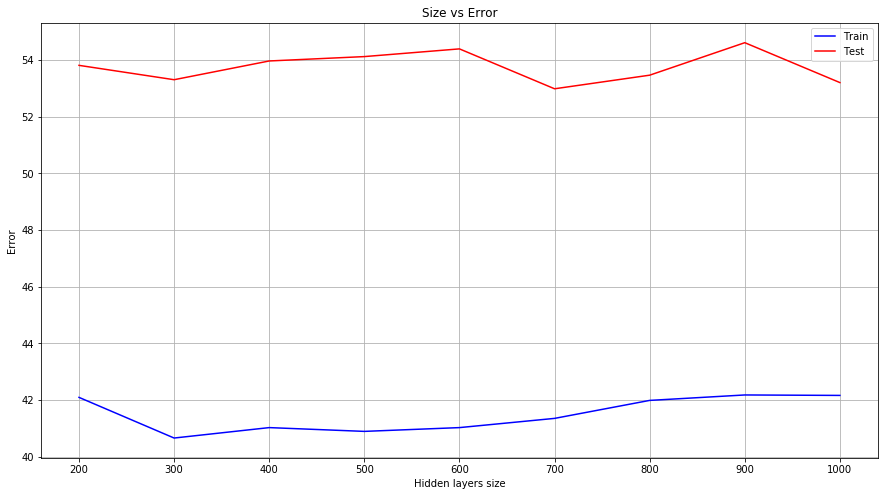

In [72]:
import matplotlib.pyplot as plt

plt.figure(figsize = (15, 8))
plt.plot(nodes_count_list, train_error_list, label = 'Train', color = 'blue')
plt.plot(nodes_count_list, test_error_list, label = 'Test', color = 'red')

plt.xlabel('Hidden layers size')
plt.ylabel('Error')
plt.title('Size vs Error')
plt.legend()
plt.grid()

Видим, что наилучшая точность на тестовых данных составляет около 47 процентов при 400 нейронах на слой (странно, что до этого было 51 при 500). Далее смотрим зависимость ошибки от L2 штрафа (weight_decay) оптимизатора Adam.

In [76]:
class Net(nn.Module):
    def __init__(self):
      super(Net, self).__init__()
      self.fc1 = nn.Linear(1202, 400)
      self.fc2 = nn.Linear(400, 400)
      self.fc3 = nn.Linear(400, 9)
    
    def forward(self, x):
      x = F.relu(self.fc1(x))
      x = F.relu(self.fc2(x))
      x = self.fc3(x)
      return F.log_softmax(x, dim=1)

weight_decays = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5, 1e-6, 1e-7, 1e-8, 1e-9, 1e-10, 1e-11, 1e-12]
train_error_list = []
test_error_list = []

for decay in weight_decays:
  print('Weight decay: {}'.format(decay))
  net = Net().double()
  optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=decay)
  criterion = nn.NLLLoss()

  epochs_count = 10
  batch_size = 100

  dataset_size = x_test.shape[0]
  batches_count = int(np.ceil(dataset_size / batch_size))

  for epoch_index in range(epochs_count):
    train_loss = 0
    correct = 0
    for batch_index in range(batches_count):
      x_var = Variable(x_train[batch_index * batch_size:batch_index * batch_size + batch_size])
      y_var = Variable(y_train[batch_index * batch_size:batch_index * batch_size + batch_size])

      optimizer.zero_grad()
      net_out = net(x_var.double())
      loss = criterion(net_out, y_var)

      train_loss += loss.item()
      pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
      correct += pred.eq(y_var.data).sum()

      loss.backward()
      optimizer.step()

  train_loss /= dataset_size
  train_percentage = 100. * correct.item() / dataset_size
  print('Train :: Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(train_loss, correct, dataset_size, train_percentage))


  dataset_size = x_test.shape[0]
  batch_size = 100
  batches_count = int(np.ceil(dataset_size / batch_size))

  test_loss = 0
  correct = 0
  for batch_index in range(batches_count):
      x_var = Variable(x_test[batch_index * batch_size:batch_index * batch_size + batch_size])
      y_var = Variable(y_test[batch_index * batch_size:batch_index * batch_size + batch_size])

      net_out = net(x_var.double())
      test_loss += criterion(net_out, y_var).item()  # суммируем потери со всех партий
      pred = net_out.data.max(1)[1]  # получаем индекс максимального значения
      correct += pred.eq(y_var.data).sum()

  test_loss /= dataset_size
  test_percentage = 100. * correct.item() / dataset_size
  print('Test :: Average loss: {:.4f}; Accuracy: {}/{} ({:.2f}%)'.format(
      test_loss, correct, dataset_size, test_percentage
  ))

  train_error_list.append(100 - train_percentage)
  test_error_list.append(100 - test_percentage)


Weight decay: 0.1
Train :: Average loss: 0.0199; Accuracy: 5216/18750 (27.82%)
Test :: Average loss: 0.0198; Accuracy: 5287/18750 (28.20%)
Weight decay: 0.01
Train :: Average loss: 0.0160; Accuracy: 8318/18750 (44.36%)
Test :: Average loss: 0.0165; Accuracy: 8138/18750 (43.40%)
Weight decay: 0.001
Train :: Average loss: 0.0133; Accuracy: 10072/18750 (53.72%)
Test :: Average loss: 0.0165; Accuracy: 8580/18750 (45.76%)
Weight decay: 0.0001
Train :: Average loss: 0.0119; Accuracy: 11019/18750 (58.77%)
Test :: Average loss: 0.0170; Accuracy: 8905/18750 (47.49%)
Weight decay: 1e-05
Train :: Average loss: 0.0117; Accuracy: 11046/18750 (58.91%)
Test :: Average loss: 0.0173; Accuracy: 8628/18750 (46.02%)
Weight decay: 1e-06
Train :: Average loss: 0.0119; Accuracy: 11007/18750 (58.70%)
Test :: Average loss: 0.0175; Accuracy: 8654/18750 (46.15%)
Weight decay: 1e-07
Train :: Average loss: 0.0116; Accuracy: 11186/18750 (59.66%)
Test :: Average loss: 0.0173; Accuracy: 8696/18750 (46.38%)
Weight dec

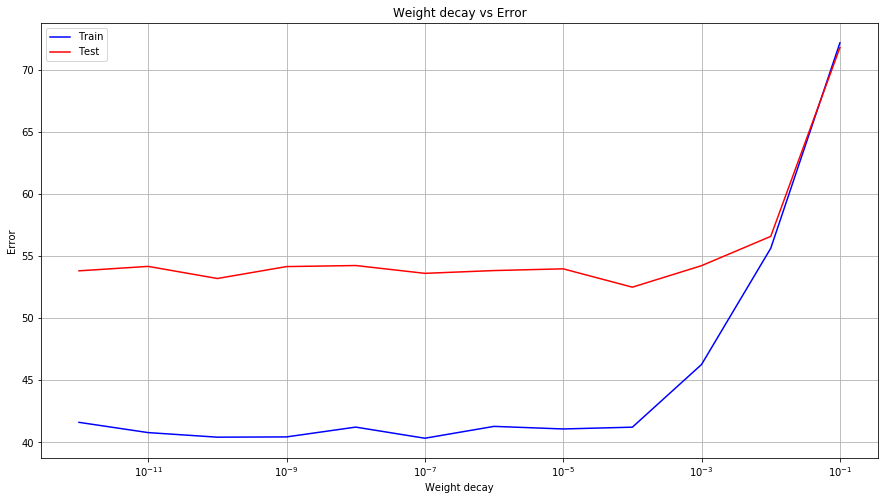

In [80]:
plt.figure(figsize = (15, 8))
plt.semilogx(weight_decays, train_error_list, label = 'Train', color = 'blue')
plt.semilogx(weight_decays, test_error_list, label = 'Test', color = 'red')

plt.xlabel('Weight decay')
plt.ylabel('Error')
plt.title('Weight decay vs Error')
plt.legend()
plt.grid()

Видим, что малых значениях штрафа точность выше до определенного момента. Наилучшая точность достигается при 1e-4. Исходя из результатов, можно заключить что переобучение не наблюдается, а даже наоборот наблюдается достаточно низкая точность на тренировочной выборке. Есть предположение, что нейросети не хватает данных для обучения. Наилучшей точностью получилось значение приблизительно в 47 процентов (47.49), что не сильно отличается от использования нейросети с нулевым L2 штрафом.